# I am going to make the automated workflow for Gaussian Plume model to the 2D transmittance image using the code below 

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_45011/1118413080.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range(start=start_time, periods=24*days, freq='H')  # Generate a pandas DatetimeIndex
/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:167: RuntimeWarning: divide by zero encountered in log
  big_theta = 0.017453293 * (c - d * np.log(total_dist[mask]))
/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:167: RuntimeWarning: invalid value encountered in log
  big_theta = 0.017453293 * (c - d * np.log(total_dist[mask]))
/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:168: RuntimeWarning: invalid value encountered in tan
  class_sigma_y[mask] = 465.11628 * total_dist[mask] * np.tan(big_theta)
/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:169: 

Grid dimensions: (100, 100, 50) (100, 100, 50) (100, 100, 50)
Times array: DatetimeIndex(['2024-08-13 18:59:46.642076', '2024-08-13 19:59:46.642076',
               '2024-08-13 20:59:46.642076', '2024-08-13 21:59:46.642076',
               '2024-08-13 22:59:46.642076', '2024-08-13 23:59:46.642076',
               '2024-08-14 00:59:46.642076', '2024-08-14 01:59:46.642076',
               '2024-08-14 02:59:46.642076', '2024-08-14 03:59:46.642076',
               '2024-08-14 04:59:46.642076', '2024-08-14 05:59:46.642076',
               '2024-08-14 06:59:46.642076', '2024-08-14 07:59:46.642076',
               '2024-08-14 08:59:46.642076', '2024-08-14 09:59:46.642076',
               '2024-08-14 10:59:46.642076', '2024-08-14 11:59:46.642076',
               '2024-08-14 12:59:46.642076', '2024-08-14 13:59:46.642076',
               '2024-08-14 14:59:46.642076', '2024-08-14 15:59:46.642076',
               '2024-08-14 16:59:46.642076', '2024-08-14 17:59:46.642076'],
              dtype='dat

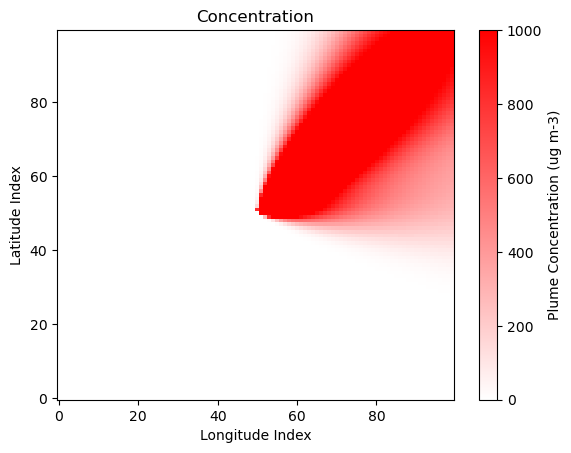

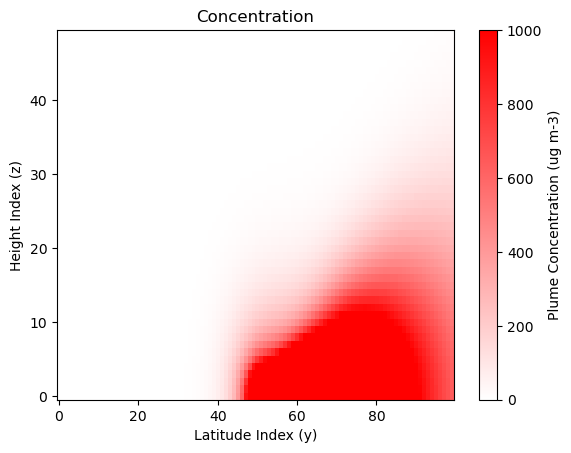

Simulation completed.


In [51]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from gaussian_puff_functions import *
from scipy.special import erfcinv

# Constants and configurations
stability_str = ['Very unstable', 'Moderately unstable', 'Slightly unstable', 'Neutral', 'Moderately stable', 'Very stable']
dxy = 20  # resolution of the model in both x and y directions (meters)
dz = 10   # resolution of the model in the z direction (meters)
num_xygrid = 100
num_zgrid = 50
days = 1  # run the model for 1 day
start_time = datetime.now()
times = pd.date_range(start=start_time, periods=24*days, freq='H')  # Generate a pandas DatetimeIndex


# Define a 3D grid using dxy and dz with the center at the source location
grid_x, grid_y, grid_z = np.meshgrid(
    np.arange(-dxy * num_xygrid/2, dxy * num_xygrid/2, dxy),  # X-axis grid
    np.arange(-dxy * num_xygrid/2, dxy * num_xygrid/2, dxy),  # Y-axis grid
    np.arange(0, dz * num_zgrid, dz),                        # Z-axis grid
    indexing='ij'
)

print("Grid dimensions:", grid_x.shape, grid_y.shape, grid_z.shape)
print("Times array:", times)

# Parameters for wind direction generation
mean_direction = 40  # Mean wind direction 
direction_spread = 20  # Spread around the mean direction

# Generate random wind directions
wind_dir = mean_direction + direction_spread * np.sqrt(2.) * erfcinv(2. * np.random.rand(24 * days, 1))

# Ensure wind directions are within 0-360 degrees
wind_dir = np.mod(wind_dir, 360)

# Print or analyze the generated wind directions
print("Wind directions:", wind_dir.flatten(), wind_dir.shape)

# Stack configurations 
stack_x = [0.]  # X-coordinates of stacks
stack_y = [0.]  # Y-coordinates of stacks
Q = [40.]       # Mass emitted per unit time in kg/s (for methane)
initial_Q = 1   # Initial emission rate in kg/s
H = [10.]       # Stack height in meters

# Iterate over each stack location
for s in range(len(H)):

    # Iterate over each wind speed (example loop, range should start from the lower bound)
    for wind_speed in range(2, 3, 1):  # Corrected to have a range with at least one value

        # Initialize concentration array
        big_C = np.zeros((grid_x.shape[0], grid_y.shape[1], grid_z.shape[2], len(wind_dir)))

        # Rough time estimate for the plume to reach steady state given the condition
        rough_steady_state_time = num_xygrid * dxy / np.sqrt(wind_speed)
        print(f"This plume will reach steady state in approximately {rough_steady_state_time} seconds")

        # Compute stability class for the entire simulation (Assume constant stability class for simplicity)
        stab_class = get_stab_class(wind_speed, times[0]) 

        print("Debug: Stability class for wind speed", wind_speed, "is", stab_class)

        # Iterate over each wind direction
        for i in range(len(wind_dir)):
            wind_direction = wind_dir[i, 0]
            
            # Convert wind direction from degrees to radians
            WA = np.radians(wind_direction)
            WA_x = np.cos(WA)
            WA_y = np.sin(WA)
            u = wind_speed * WA_x
            v = wind_speed * WA_y

            print("winds speed ", wind_speed, "wind_direction ", WA, "cos(win_direction) ", WA_x, "sin(win_direction) ", WA_y)
            
            # Compute concentrations using the Gaussian Plume model
            concentrations = gplume(initial_Q, stab_class, stack_x[s], stack_y[s], H[s], grid_x, grid_y, grid_z, wind_speed,  WA_x, WA_y)
            
            # Accumulate concentrations over time
            big_C[:, :, :, i] += concentrations  # Convert to appropriate units

            print(f"Debug: Plume at direction {wind_direction:.2f} degrees, concentration array shape:", big_C.shape)

        # Average over wind directions
        mean_conc = np.mean(big_C, axis=3)
        
        # Plotting the 2D plume concentration (implement plot_2d_plume_concentration in your functions)
        plot_2d_plume_concentration(mean_conc)

print("Simulation completed.")

target wavelength 2 [2.29  2.295]


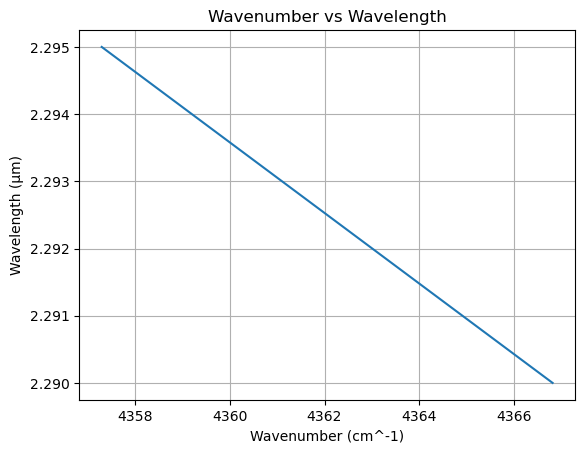

Using /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran

CH4
                     Lines parsed: 1140
H2O
                     Lines parsed: 11257

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CH4
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
Header written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.header
END DOWNLOAD
                     Lines parsed: 1140
PROCESSED
-----------------------------------------
CH4 summary:
-----------------------------------------
Comment: 
Contains lines for (12C)H4
 in 4357.298-4366.812 wavenumber range
Number of rows: 1140
Table type: column-fixed
-----------------------------------------
            PAR_NAME   

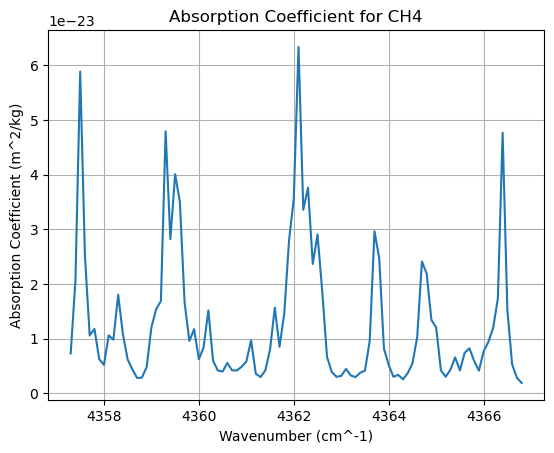

In [52]:
from hapi import *
import ssl
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt


# Set necessary for accessing HITRAN database 
os.environ['GLOBAL_HOST'] = 'http://hitran.org'
ssl._create_default_https_context = ssl._create_unverified_context

# Set wavelength range and spectral resolution (you can match it with satellite)
# For Sentinel-2, the most useful band is 2.3 um. 
wavelength_limits = [2.29, 2.30] # micro meters
spectral_resolution = 0.005 # micro meters

#Compute wavelength range and wavenumber in cm^-1
target_wavelength = np.arange(wavelength_limits[0], wavelength_limits[1], spectral_resolution)
wavenumbers = 1.e4 / target_wavelength

print("target wavelength", len(target_wavelength), target_wavelength)

# Plotting the relationship between wavelength and wavenumber
plt.plot(wavenumbers, target_wavelength)
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Wavelength (µm)')
plt.title('Wavenumber vs Wavelength')
plt.grid(True)
plt.show()

# Set the local folder to download the HITRAN data
db_begin('/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran')
fetch('CH4',6,1,wavenumbers[1],wavenumbers[0])
describeTable('CH4')

# HITRAN_units : cm^2/molec (if True) and cm-1 (if False) and  WavenumberStep default value is 0.01 cm-1 but changed to 1 for now
nu,abs_coef = absorptionCoefficient_Lorentz(SourceTables='CH4', Diluent={'air':1.0}, HITRAN_units=True, Environment ={'T':296.,'p':1.}, WavenumberStep = 0.1)

print(len(abs_coef), len(target_wavelength))

# convert cm^2/mole to m2/kg, which is the concentration unit from the Gaussian Model. 
ch4_molar_weight = 0.01604 # kg/mole 
convert_unit = 1/ch4_molar_weight/1e4 # cm2/mole to m2/kg
abs_coef= abs_coef*convert_unit

# Plot the absorption coefficient
plt.plot(nu, abs_coef)
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorption Coefficient (m^2/kg)')
plt.title('Absorption Coefficient for CH4')
plt.grid(True)
plt.show()


In [53]:
print(mean_conc.shape)

# linear increase with emission and convert mean concentration from ug m-3 to kg m-3
Q_target = 10000 # kg/hr  # kg/s
mean_conc = mean_conc /1e9 * (Q_target/3600) # kg/m-3 

print(mean_conc.mean(),abs_coef.mean() )

(100, 100, 50)
8.77001724758148e-07 1.2876945278688276e-23


extinction per layer  (100, 100, 50, 96) 1.1293103219025886e-28
total_extinction  (100, 100, 96)
final_data  (100, 100) 5.646551609512954e-27


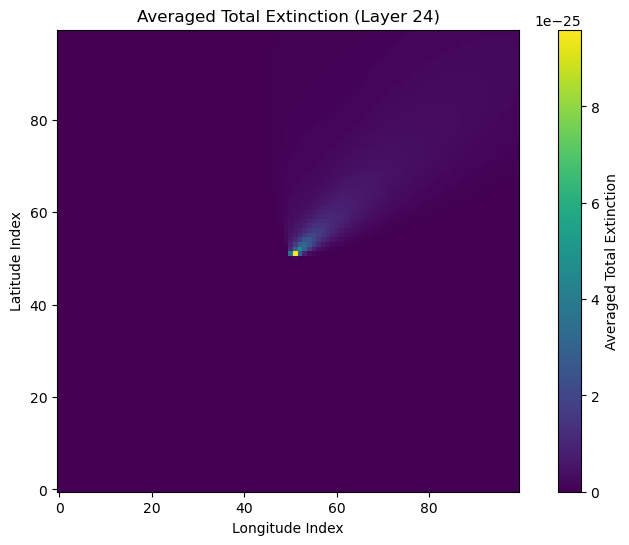

total_transmittance  (100, 100) 1.0


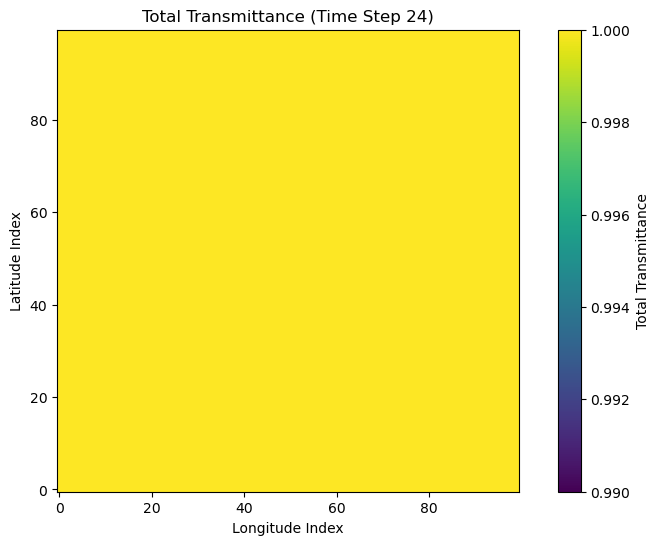

In [54]:


# Reshape the arrays to be 5D dimensions to compute extinction
value_reshaped = mean_conc[:, :, :,  np.newaxis]  # (lon, lat, height, 1)
wavenumber_dim = len(abs_coef)
abs_coef_reshaped = abs_coef.reshape(1, 1, 1, wavenumber_dim)
extinction_per_layer = value_reshaped * dz * abs_coef_reshaped # dz = 10 (grid height) 
print("extinction per layer ", extinction_per_layer.shape, extinction_per_layer.mean())

# Summing over height
total_extinction = np.sum(extinction_per_layer, axis=2)  
print("total_extinction ", total_extinction.shape)

# Average over the last dimension, wavenumbers
final_data = np.mean(total_extinction, axis=-1)  # Resulting shape will be (lon, lat)
print("final_data ", final_data.shape, final_data.mean())


plt.figure(figsize=(10, 6))
plt.imshow(final_data[:, :], cmap='viridis', origin='lower')
plt.colorbar(label='Averaged Total Extinction')
plt.title(f'Averaged Total Extinction (Layer {i+1})')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()


# Calculate total transmittance based on Beer-Lambert Law
final_transmittance = np.exp(-final_data)
print("total_transmittance ", final_transmittance.shape, final_transmittance.mean())


plt.figure(figsize=(10, 6))
plt.imshow(final_transmittance[:, :], cmap='viridis', origin='lower', vmin =0.99, vmax = 1)
plt.colorbar(label='Total Transmittance')
plt.title(f'Total Transmittance (Time Step {i+1})')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

total_transmittance  (100, 100)


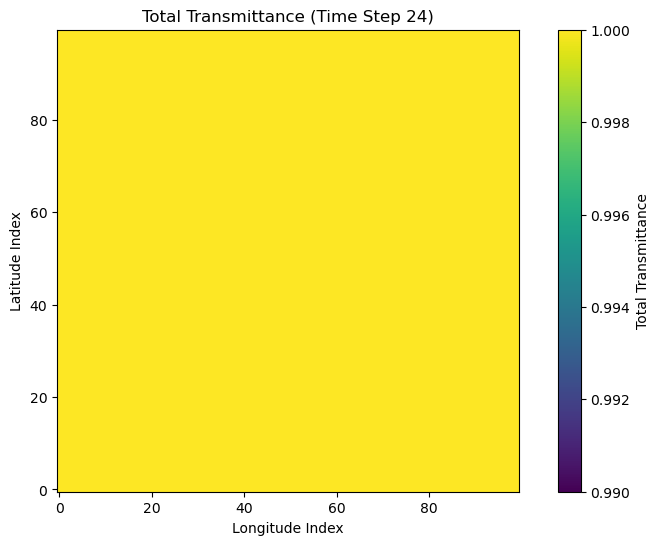

In [55]:
# Calculate total transmittance based on Beer-Lambert Law
final_transmittance = np.exp(-final_data)
print("total_transmittance ", final_transmittance.shape)


plt.figure(figsize=(10, 6))
plt.imshow(final_transmittance[:, :], cmap='viridis', origin='lower', vmin =0.99, vmax = 1)
plt.colorbar(label='Total Transmittance')
plt.title(f'Total Transmittance (Time Step {i+1})')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

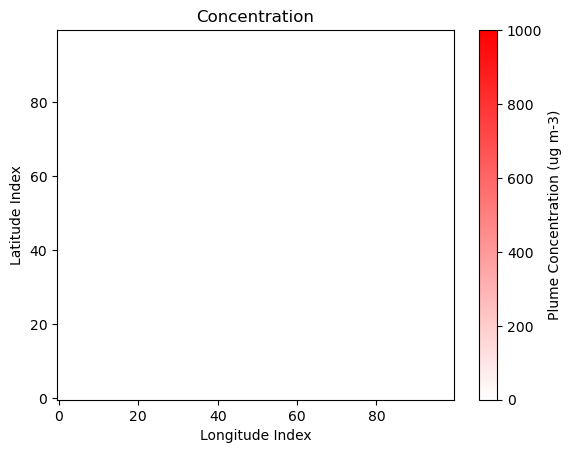

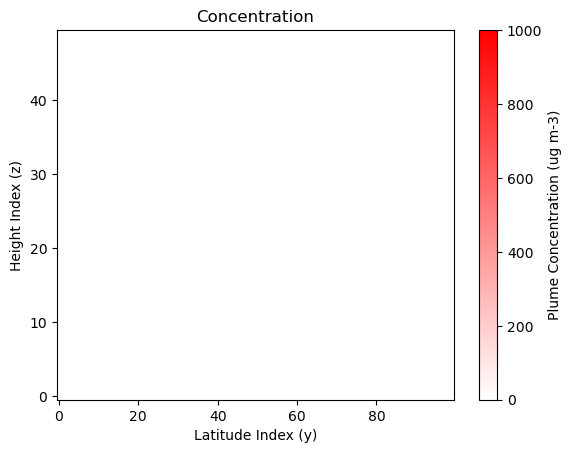

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap 

def plot_2d_plume_concentration(big_C):
    colors = ["white", "red"]  # white for low concentrations, red for high
    cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=256)
    
    fig, ax = plt.subplots()

    # Sum over the Z-axis (height dimension)
    C_summed = np.mean(big_C, axis=2)

    # Create the heatmap
    c = ax.imshow(C_summed.T, cmap=cmap, origin='lower', aspect='auto', vmin=0, vmax = 1000)
    ax.set_title('Concentration')
    ax.set_xlabel('Longitude Index')
    ax.set_ylabel('Latitude Index')

    # Add a color bar
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Plume Concentration (ug m-3)')

    # Sum over the X (longitude dimension)
    C_summed = np.mean(big_C, axis=0)

    # Create the plot
    fig, ax = plt.subplots()

    # Plotting with y on the x-axis and z on the y-axis
    c = ax.imshow(C_summed.T, cmap=cmap, origin='lower', aspect='auto', vmin=0, vmax=1000)

    ax.set_title('Concentration')
    ax.set_xlabel('Latitude Index (y)')
    ax.set_ylabel('Height Index (z)')

    # Add a color bar
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Plume Concentration (ug m-3)')

    # Display the plot
    plt.show()

plot_2d_plume_concentration(mean_conc)

# read carbonmapper plume image to get the concentration range



DataArray info:
<xarray.DataArray (band: 4, y: 151, x: 151)> Size: 91kB
[91204 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
    xc           (y, x) float64 182kB 3.607e+05 3.607e+05 ... 3.612e+05
    yc           (y, x) float64 182kB 3.799e+06 3.799e+06 ... 3.799e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


(array([9.0059e+04, 1.6100e+02, 1.5100e+02, 1.9700e+02, 1.0200e+02,
        6.9000e+01, 5.6000e+01, 6.9000e+01, 1.0600e+02, 2.3400e+02]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

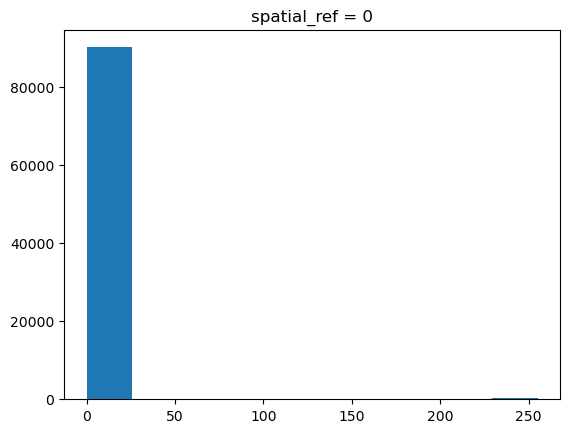

In [57]:
import xarray as xr
import rioxarray

# Path to the GeoTIFF file
file = "/Users/yunhalee/Documents/methanDart/carbonmapper/CarbonMapper_Aerial/carbonmapper_ch4_rgb_geotiffs_2020_2021/carbonmapper_ch4_rgb_geotiffs_2020_2021/ang20200708t192518-3_r1823_c108_ctr.tif"

# Open the GeoTIFF file as an xarray DataArray
data = rioxarray.open_rasterio(file)

# Display basic information about the data
print("DataArray info:")
print(data)

# Plotting the first band (or all bands if it's a multi-band image)
data.plot()



('band', 'y', 'x')
Coordinates:
  * band         (band) int64 32B 1 2 3 4
    xc           (y, x) float64 182kB 3.607e+05 3.607e+05 ... 3.612e+05
    yc           (y, x) float64 182kB 3.799e+06 3.799e+06 ... 3.799e+06
    spatial_ref  int64 8B 0
{'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}
CRS: EPSG:32611
Bounds: (360660.9674670138, 3798675.389420468, 361053.5674670138, 3799067.989420468)


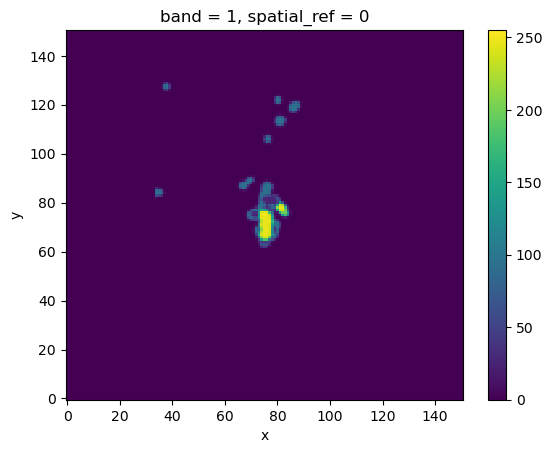

In [58]:
print(data.dims)  # Dimensions of the array (e.g., 'band', 'y', 'x')
print(data.coords)  # Coordinates of the array (e.g., 'band', 'y', 'x')
print(data.attrs)  # Attributes (metadata) of the array

band1 = data.sel(band=1)  # Select the first band
band1.plot()  # Plot the first band

print("CRS:", data.rio.crs)  # Coordinate reference system
print("Bounds:", data.rio.bounds())  # Geospatial bounds of the image
